<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/exp_binary/project_ray_4_VGG16_precision_91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 34.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.7MB/s]


In [ ]:
!unzip \*.zip

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = [224, 224]

train_path = '/content/chest_xray/chest_xray/train'
valid_path = '/content/chest_xray/chest_xray/test'

In [6]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
folders = glob('/content/Kaggle/chest_xray/chest_xray/train/*')
folders

['/content/Kaggle/chest_xray/chest_xray/train/NORMAL',
 '/content/Kaggle/chest_xray/chest_xray/train/PNEUMONIA']

In [8]:
from keras.layers import Dropout
x = Flatten(name='flatten')(vgg.output)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(0.5, name='drop1')(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dropout(0.5, name='drop2')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

In [9]:
model = Model(inputs=vgg.input, outputs=x)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:

model.compile(
  loss='binary_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


In [14]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [20]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            shuffle=False,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


In [16]:
val_set = val_datagen.flow_from_directory('/content/chest_xray/chest_xray/val',
                                            target_size = (224, 224),
                                            class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [19]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)
callbacks_list = [ early, learning_rate_reduction]

In [21]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  callbacks=callbacks_list
)

Epoch 1/20
82/82 [==============================] - 126s 1s/step - loss: 0.6802 - accuracy: 0.7678 - val_loss: 0.3284 - val_accuracy: 0.8718
Epoch 2/20
82/82 [==============================] - 115s 1s/step - loss: 0.1929 - accuracy: 0.9281 - val_loss: 0.3152 - val_accuracy: 0.8990
Epoch 3/20
82/82 [==============================] - 116s 1s/step - loss: 0.1667 - accuracy: 0.9434 - val_loss: 0.3278 - val_accuracy: 0.8766
Epoch 4/20
82/82 [==============================] - 116s 1s/step - loss: 0.1847 - accuracy: 0.9315 - val_loss: 0.3386 - val_accuracy: 0.8942

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/20
82/82 [==============================] - 115s 1s/step - loss: 0.1556 - accuracy: 0.9431 - val_loss: 0.3206 - val_accuracy: 0.9054


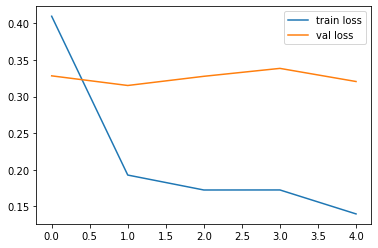

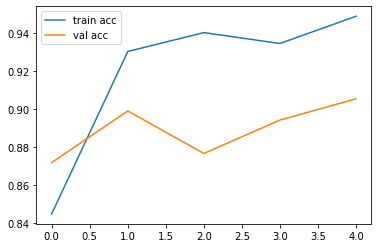

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
model.evaluate(training_set)

82/82 [==============================] - 98s 1s/step - loss: 0.0405 - accuracy: 0.9864


[0.04048258066177368, 0.9863880276679993]

In [23]:
model.evaluate(test_set)

10/10 [==============================] - 6s 554ms/step - loss: 0.3206 - accuracy: 0.9054


[0.32063955068588257, 0.9054487347602844]

In [24]:
preds_binary = model.predict(test_set,verbose=1)


10/10 [==============================] - 6s 539ms/step


In [27]:
predictions = preds_binary.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

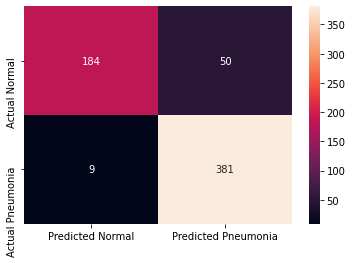

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [36]:
print(classification_report(y_true=test_set.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.91      0.90       624



In [42]:
import matplotlib.pyplot as plt #For Visualization
import numpy as np
test_set.reset()
x=np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y=np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(x.shape)
print(y.shape)

(624, 224, 224, 3)
(624,)


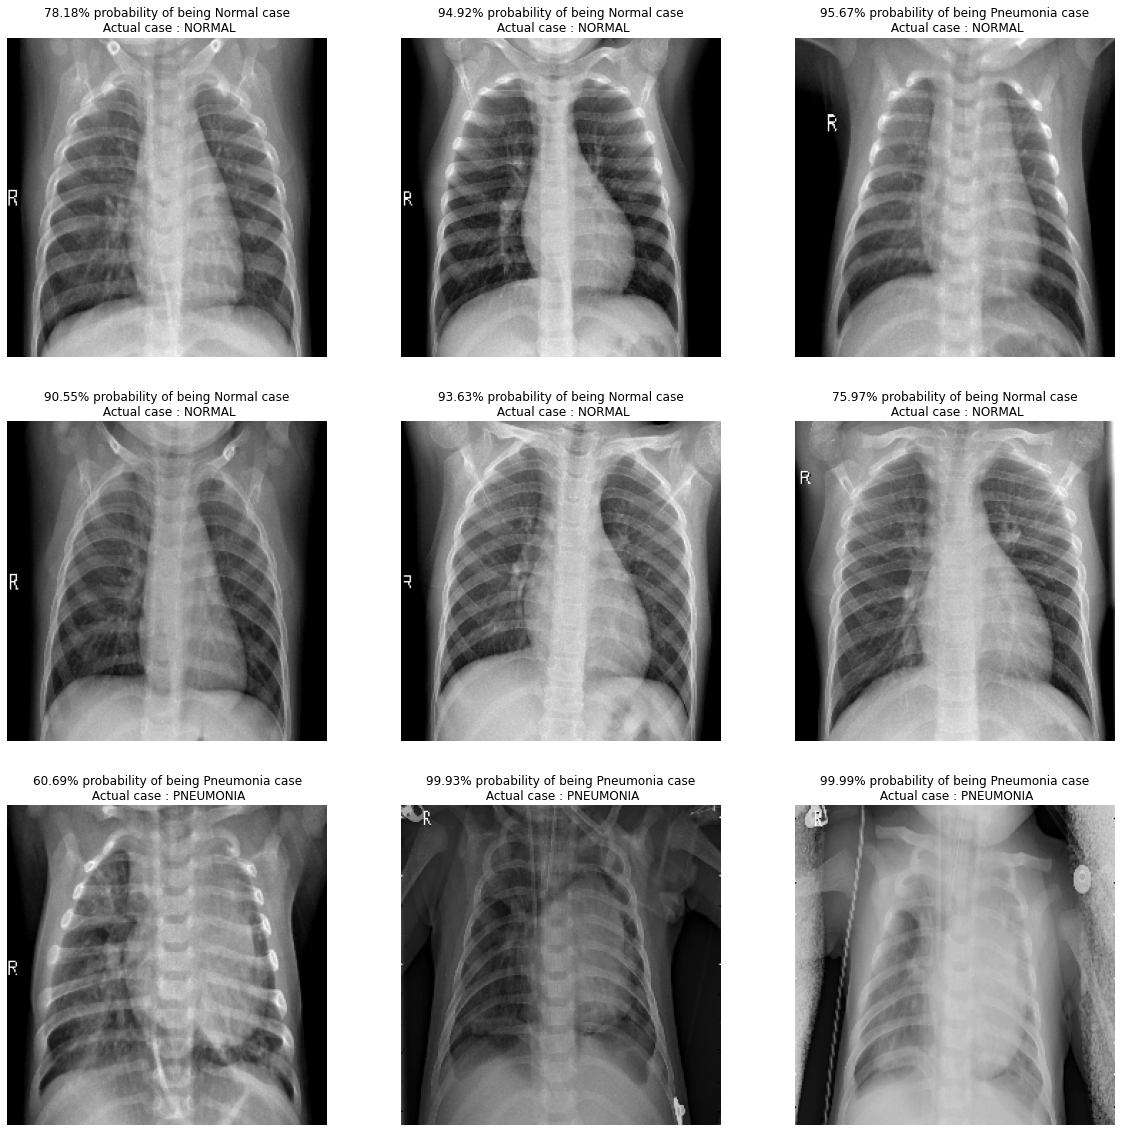

In [44]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds_binary[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds_binary[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds_binary[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [ ]:
%cd /content/drive/MyDrive/Kaggle
%ls

/content/drive/MyDrive/Kaggle
AccVal_acc.png  Inceptv3_xray.h5  LossVal_loss.png  model_vgg19.h5
chest_xray/     kaggle.json       model_vgg16.h5


In [ ]:

from keras.models import load_model

model.save('model_vgg16_Precision_85.h5')

In [ ]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

1e-04


In [ ]:
img = image.load_img('/content/Kaggle/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg', target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

In [ ]:
classes

array([[1., 0.]], dtype=float32)

In [ ]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

In [ ]:
TRAIN_DIR = "/content/chest_xray/chest_xray/train/"
TEST_DIR =  "/content/chest_xray/chest_xray/test/"

In [ ]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [ ]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (224, 224, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [ ]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (224, 224, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [ ]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 390/390 [00:41<00:00,  9.42it/s]


In [ ]:
from keras.utils.np_utils import to_categorical
y_test = to_categorical(y_test, 2)


In [ ]:
print(y_test.shape)

(624, 2)


In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

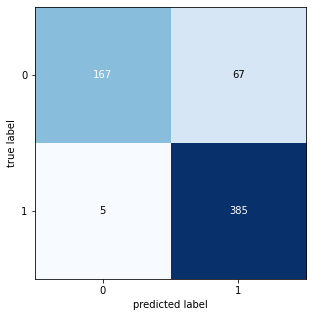

In [ ]:
cm = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

In [ ]:
print('True Positive  (TP) = ', cm[1][1])
print('False Positive (FP) = ', cm[0][1])
print('False Negative (FN) = ', cm[1][0])
print('True Negative  (TN) = ', cm[0][0])
print('-'*26)

True Positive  (TP) =  385
False Positive (FP) =  67
False Negative (FN) =  5
True Negative  (TN) =  167
--------------------------


In [ ]:
if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      accuracy=  round((cm[1][1] + cm[0][0]) / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])*100, 2)
      precision= round((cm[1][1] / (cm[1][1] + cm[0][1]))*100, 2) 
      recall   = round((cm[1][1] / (cm[1][1] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)  
      print(f'accuracy Score: {accuracy}%')     
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')

accuracy Score: 88.46%
Precision Score: 85.18%
Recall Score: 98.72%
F1 Score: 91.45%




In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm4= confusion_matrix(y_true, pred)
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82       234
           1       0.85      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.88      0.88       624

